#BERT fine-tuning.

In this notebook we are going to solve our sentiment analysis problem by  fine-tuning powerful pretrained language model named BERT. To run this code in Google Colab we need to install [huggingface transformers](https://huggingface.co/transformers/index.html) library, which provides pretrained transformer models and tools for working with them.

In [ ]:
!pip install transformers

In [ ]:
import os
import random
from IPython.display import clear_output
from tqdm import tqdm, trange
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchtext.datasets import IMDB

import numpy as np
from matplotlib import pyplot as plt

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW

from utils import *

In [ ]:
warnings.filterwarnings('ignore')

##Data preparation.

Here we will load our dataset using torchtext.datasets, but for BERT we will not use torchtext tokenizer, but [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html?highlight=berttokenizer#transformers.BertTokenizer) provided by huggingface transformers. This is necessary to keep compliance of word-to-index mapping with the one used in BERT training.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    DEVICE = torch.device('cuda:0')
else:
    DEVICE = torch.device('cpu')
DEVICE

device(type='cuda', index=0)

In [ ]:
train_data, test_data = IMDB(split=('train', 'test'))

In [ ]:
val_size = len(train_data) // 10
data = list(train_data)
random.shuffle(data)

train_data, val_data = data[:-val_size], data[-val_size:]

test_data = list(test_data)

print(len(train_data), len(val_data), len(test_data))

22500 2500 25000


We need some preprocessing function to transform all sentences and their labels to understandable for BERT form. 


Here we will truncate or pad all texts to be of the same length of 200 tokens. We can note that for attentive models truncate value was set to 500. The point is that smaller value is a need for BERT to fit amount of GPU memory.  We believe that advantages of BERT will beat that change in texts lengths.

In this notebook we will set batch size to be equal to 16 (which is even smaller than in previous notebooks) and it has the same technical reasons.

In [ ]:
def preprocess_data_for_bert(data, tokenizer, device=DEVICE, max_length=200):
    label_transform = lambda x: 1 if x == 'pos' else 0

    input_ids = []
    attention_masks = []
    labels = []

    for label, text in tqdm(data, position=0):
        encoded_dict = tokenizer.encode_plus(
                            text,                    
                            add_special_tokens=True, 
                            max_length=max_length,
                            truncation=True,         
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt'
                        )
          
        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

        labels.append(label_transform(label))

    input_ids = torch.cat(input_ids, dim=0).to(DEVICE)
    attention_masks = torch.cat(attention_masks, dim=0).to(DEVICE)
    labels = torch.tensor(labels).to(DEVICE)

    return TensorDataset(input_ids, attention_masks, labels)

In [ ]:
train_dataset = preprocess_data_for_bert(train_data, tokenizer, device=DEVICE)
val_dataset = preprocess_data_for_bert(val_data, tokenizer, device=DEVICE)
test_dataset = preprocess_data_for_bert(test_data, tokenizer, device=DEVICE)

100%|██████████| 25000/25000 [02:14<00:00, 185.93it/s]


In [ ]:
BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              drop_last=True)

val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                            drop_last=True)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

##Model architecture.

We will use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html?highlight=bertforsequenceclassification#transformers.BertForSequenceClassification) which is a model for classification tasks. It uses a special [CLS] token at the start of each input text and has a classification head on top of last transformer's output for this token to predict logits of probabilities of belonging to different classes. 

We will use bert-base-uncased model, which consists of embedding layer, 12 transformer layers and output layer. Let's load the model and look at it's parts and parameters.

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Last Transformer ====\n')

for p in params[-20:-4]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

We will also create a function to load BERT and optimizer for it (because we will train it many times in different way and compare the scores). Here we use [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html?highlight=adamw#transformers.AdamW) optimizer with learning rate 0.0002 as one of default values used in [the paper](https://arxiv.org/pdf/1810.04805.pdf).

In [ ]:
def get_bert_with_optimizer(name, device=DEVICE):
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    ).to(device)
    model.name = name
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    return model, optimizer

##Experiments.


In this section we are going to fine-tune BERT. We can try different numbers of last unfrozen layers and compare the results according to training, evaluation time and obtained scores. We will try the following approaches:


1) Unfreeze only linear classifier.

2) Unfreeze linear classifier and last transformer.

3) Unfreeze linear classifier and last 6 transformers.

4) Unfreeze the complete BERT with classifier, all 12 transformers and embedding layer.

The more layers we unfreeze, the more time each epoch takes, so main question is how faster training becomes after unfreezing more layers and are training time and results worth it.

###Unfreezing only linear classifier.

To do this we need to set requires_grad attribure to False for all model parameters except last 4 (as shown in Model architecture part). We will then train the model for 4 epochs.

In [ ]:
model, optimizer = get_bert_with_optimizer('BertForSequenceClassification with fine-tuned classifier')

n_parameters = len(list(model.parameters()))

for i, param in enumerate(model.parameters()):
    if i < n_parameters - 4:
        param.requires_grad = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
metrics = train_bert(model, optimizer, train_dataloader, val_dataloader, device=DEVICE, n_epochs=4)


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  1,406.    Elapsed: 0:00:21.
  Batch   200  of  1,406.    Elapsed: 0:00:43.
  Batch   300  of  1,406.    Elapsed: 0:01:04.
  Batch   400  of  1,406.    Elapsed: 0:01:24.
  Batch   500  of  1,406.    Elapsed: 0:01:45.
  Batch   600  of  1,406.    Elapsed: 0:02:07.
  Batch   700  of  1,406.    Elapsed: 0:02:28.
  Batch   800  of  1,406.    Elapsed: 0:02:49.
  Batch   900  of  1,406.    Elapsed: 0:03:10.
  Batch 1,000  of  1,406.    Elapsed: 0:03:31.
  Batch 1,100  of  1,406.    Elapsed: 0:03:52.
  Batch 1,200  of  1,406.    Elapsed: 0:04:13.
  Batch 1,300  of  1,406.    Elapsed: 0:04:34.
  Batch 1,400  of  1,406.    Elapsed: 0:04:55.

  Average training loss: 0.55
  Training epoch took: 0:04:56

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.46
  Validation took: 0:00:32

======== Epoch 2 / 4 ========
Training...
  Batch   100  of  1,406.    Elapsed: 0:00:21.
  Batch   200  of  1,406.    Elapsed: 0:00:42.
  Batch  

As we can see, training and validation loss increased very slowly and validation accuracy reached only 0.82 after 22 minutes of training. It can be explained by small size of classifier (which is only a 2-layer fully-connected network), so it may be useful to unfreeze more complicated layers if BERT to fit our dataset better.

The following results show that this model didn't even fit training dataset well, so much longer training could probably lead to better results.

Scores for BertForSequenceClassification with fine-tuned classifier:
Accuracy: 0.8311699857752489
Precision: 0.8294992036807645
Recall: 0.8336297350168949
Area under ROC-curve: 0.9079


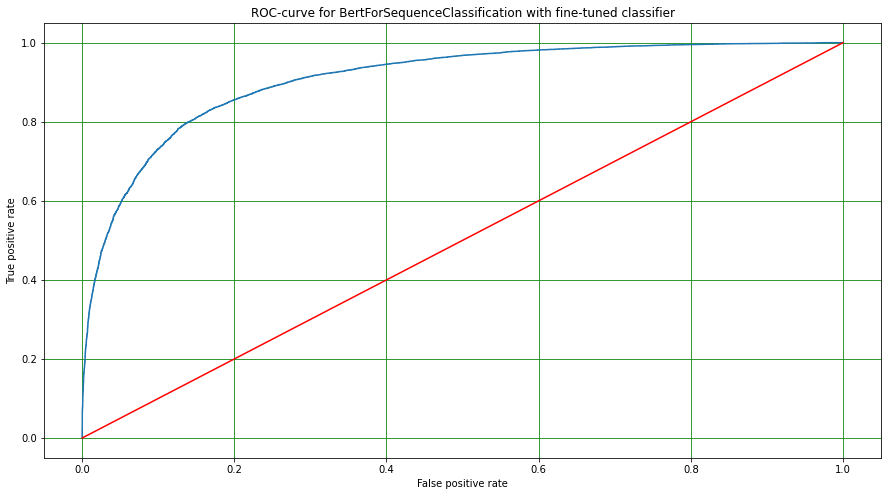

In [ ]:
model.eval()
get_scores(model, train_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, train_dataloader, get_function=get_all_y_for_bert)

Scores for BertForSequenceClassification with fine-tuned classifier:
Accuracy: 0.82772
Precision: 0.8280086476098967
Recall: 0.82728
Area under ROC-curve: 0.9070


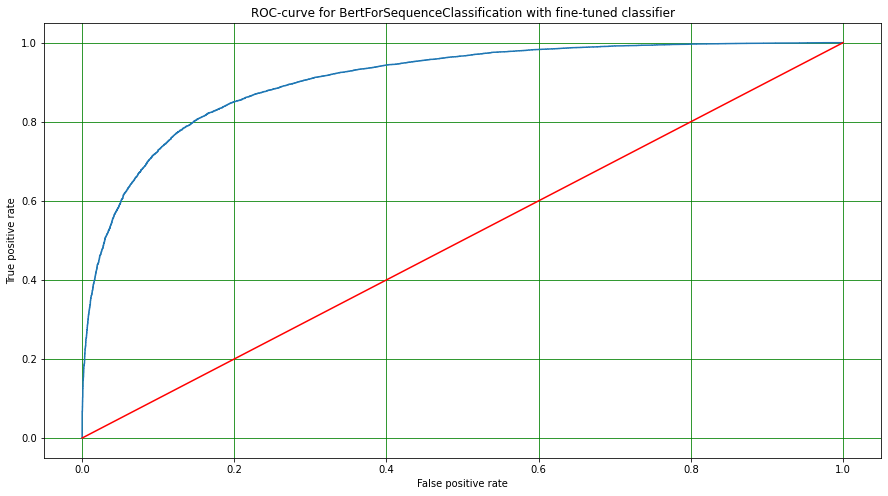

In [ ]:
get_scores(model, test_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, test_dataloader, get_function=get_all_y_for_bert)

###Unfreezing linear classifier and last transformer.

Each transformer has 16 learnable layers in model architecture, so in this part we will unfreeze 4 + 16 last layers and train the model for 4 epochs.

In [ ]:
model, optimizer = get_bert_with_optimizer('BertForSequenceClassification with fine-tuned classifier and last transformer')

n_parameters = len(list(model.parameters()))

for i, param in enumerate(model.parameters()):
    if i < n_parameters - 4 - 16:
        param.requires_grad = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
metrics = train_bert(model, optimizer, train_dataloader, val_dataloader, device=DEVICE, n_epochs=4)


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  1,406.    Elapsed: 0:00:23.
  Batch   200  of  1,406.    Elapsed: 0:00:48.
  Batch   300  of  1,406.    Elapsed: 0:01:11.
  Batch   400  of  1,406.    Elapsed: 0:01:34.
  Batch   500  of  1,406.    Elapsed: 0:01:58.
  Batch   600  of  1,406.    Elapsed: 0:02:22.
  Batch   700  of  1,406.    Elapsed: 0:02:45.
  Batch   800  of  1,406.    Elapsed: 0:03:09.
  Batch   900  of  1,406.    Elapsed: 0:03:32.
  Batch 1,000  of  1,406.    Elapsed: 0:03:56.
  Batch 1,100  of  1,406.    Elapsed: 0:04:19.
  Batch 1,200  of  1,406.    Elapsed: 0:04:43.
  Batch 1,300  of  1,406.    Elapsed: 0:05:07.
  Batch 1,400  of  1,406.    Elapsed: 0:05:30.

  Average training loss: 0.35
  Training epoch took: 0:05:32

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.29
  Validation took: 0:00:32

======== Epoch 2 / 4 ========
Training...
  Batch   100  of  1,406.    Elapsed: 0:00:24.
  Batch   200  of  1,406.    Elapsed: 0:00:47.
  Batch  

Validation accuracy is not sufficiently big, so we can evaluate model and hope for really good scores.

Scores for BertForSequenceClassification with fine-tuned classifier and last transformer:
Accuracy: 0.9194078947368421
Precision: 0.917722079532371
Recall: 0.9213942735194736
Area under ROC-curve: 0.9745


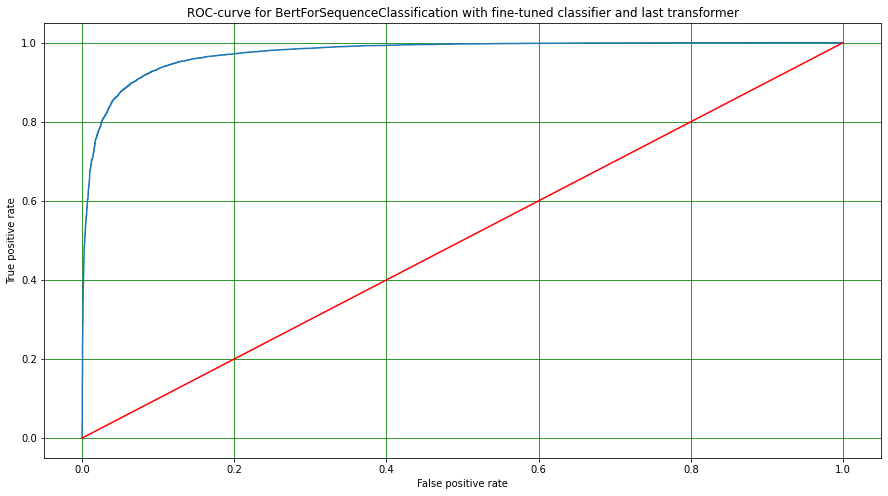

In [ ]:
model.eval()
get_scores(model, train_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, train_dataloader, get_function=get_all_y_for_bert)

Scores for BertForSequenceClassification with fine-tuned classifier and last transformer:
Accuracy: 0.89604
Precision: 0.8936153295698497
Recall: 0.89912
Area under ROC-curve: 0.9618


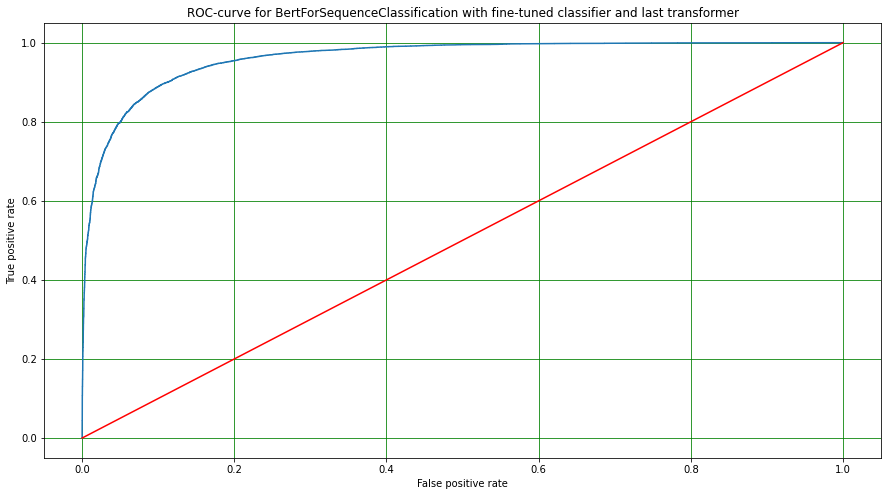

In [ ]:
get_scores(model, test_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, test_dataloader, get_function=get_all_y_for_bert)

Great results! We have new best accuracy and roc-auc score. We can admit that training took 24 minutes, which is just a bit longer than previous model, so unfreezing transformer was very important. Other interesting notice is that training scores are still not very large, so there is no overfitting and maybe we canget some better scores by training for some more epochs.

###Unfreezing linear classifier and last 6 transformers.


Is this part we will unfreeze a half of transformer part of the network. It would make training much longer, so we will reduce the number of training epochs. The reason for that is also the fact that training a large part of the model for many epochs may cause overfitting (it is shown in the last section of this notebook). So here we will train our model for 2 epochs.

In [ ]:
model, optimizer = get_bert_with_optimizer('BertForSequenceClassification with fine-tuned classifier and last 6 transformers')

n_parameters = len(list(model.parameters()))

for i, param in enumerate(model.parameters()):
    if i < n_parameters - 4 - 6 * 16:
        param.requires_grad = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
metrics = train_bert(model, optimizer, train_dataloader, val_dataloader, device=DEVICE, n_epochs=2)


======== Epoch 1 / 2 ========
Training...
  Batch   100  of  1,406.    Elapsed: 0:00:37.
  Batch   200  of  1,406.    Elapsed: 0:01:17.
  Batch   300  of  1,406.    Elapsed: 0:01:56.
  Batch   400  of  1,406.    Elapsed: 0:02:36.
  Batch   500  of  1,406.    Elapsed: 0:03:15.
  Batch   600  of  1,406.    Elapsed: 0:03:55.
  Batch   700  of  1,406.    Elapsed: 0:04:34.
  Batch   800  of  1,406.    Elapsed: 0:05:14.
  Batch   900  of  1,406.    Elapsed: 0:05:53.
  Batch 1,000  of  1,406.    Elapsed: 0:06:32.
  Batch 1,100  of  1,406.    Elapsed: 0:07:12.
  Batch 1,200  of  1,406.    Elapsed: 0:07:51.
  Batch 1,300  of  1,406.    Elapsed: 0:08:30.
  Batch 1,400  of  1,406.    Elapsed: 0:09:10.

  Average training loss: 0.30
  Training epoch took: 0:09:12

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.24
  Validation took: 0:00:32

======== Epoch 2 / 2 ========
Training...
  Batch   100  of  1,406.    Elapsed: 0:00:39.
  Batch   200  of  1,406.    Elapsed: 0:01:19.
  Batch  

Validation accuracy of the model looks really promising, so let's now evaluate it.

Scores for BertForSequenceClassification with fine-tuned classifier and last 6 transformers:
Accuracy: 0.9626155761024182
Precision: 0.9737081513828238
Recall: 0.9509551310528654
Area under ROC-curve: 0.9931


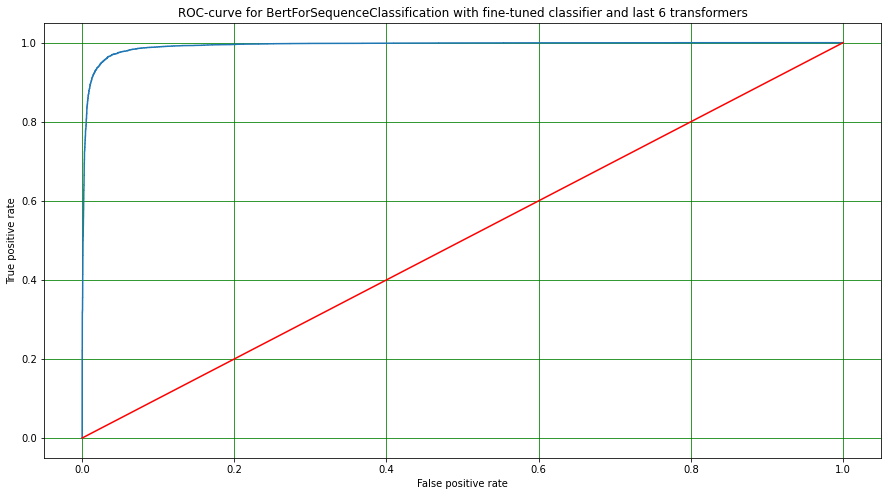

In [ ]:
model.eval()
get_scores(model, train_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, train_dataloader, get_function=get_all_y_for_bert)

Scores for BertForSequenceClassification with fine-tuned classifier and last 6 transformers:
Accuracy: 0.90904
Precision: 0.9265098431765099
Recall: 0.88856
Area under ROC-curve: 0.9709


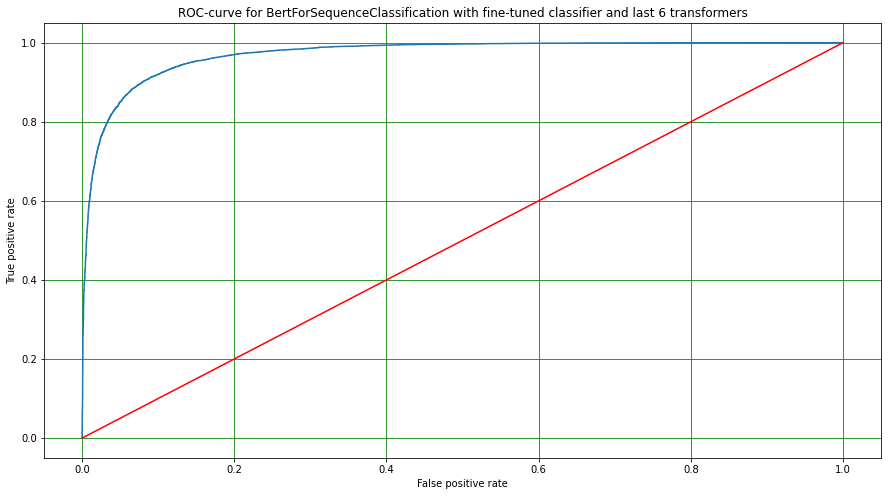

In [ ]:
get_scores(model, test_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, test_dataloader, get_function=get_all_y_for_bert)

Test accuracy increased to 90.9% which is a great result. The main advantage is that this model trained for even less time than previous ones!

###Unfreezing the complete BERT with classifier, all 12 transformers and embedding layer.

In this part we will not freeze any parameters at all. Now the obtained training part of the model is really huge, so we will probably need no more than one epoch for training.

In [ ]:
model, optimizer = get_bert_with_optimizer('BertForSequenceClassification fine-tuned completely')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
metrics = train_bert(model, optimizer, train_dataloader, val_dataloader, device=DEVICE, n_epochs=1)


======== Epoch 1 / 1 ========
Training...
  Batch   100  of  1,406.    Elapsed: 0:00:55.
  Batch   200  of  1,406.    Elapsed: 0:01:52.
  Batch   300  of  1,406.    Elapsed: 0:02:51.
  Batch   400  of  1,406.    Elapsed: 0:03:51.
  Batch   500  of  1,406.    Elapsed: 0:04:51.
  Batch   600  of  1,406.    Elapsed: 0:05:52.
  Batch   700  of  1,406.    Elapsed: 0:06:53.
  Batch   800  of  1,406.    Elapsed: 0:07:54.
  Batch   900  of  1,406.    Elapsed: 0:08:55.
  Batch 1,000  of  1,406.    Elapsed: 0:09:55.
  Batch 1,100  of  1,406.    Elapsed: 0:10:56.
  Batch 1,200  of  1,406.    Elapsed: 0:11:57.
  Batch 1,300  of  1,406.    Elapsed: 0:12:58.
  Batch 1,400  of  1,406.    Elapsed: 0:13:58.

  Average training loss: 0.30
  Training epoch took: 0:14:02

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.23
  Validation took: 0:00:32

Training complete!
Total training took 0:14:34 (h:mm:ss)


Scores for BertForSequenceClassification fine-tuned completely:
Accuracy: 0.9555032005689901
Precision: 0.959383125616426
Recall: 0.951280227596017
Area under ROC-curve: 0.9901


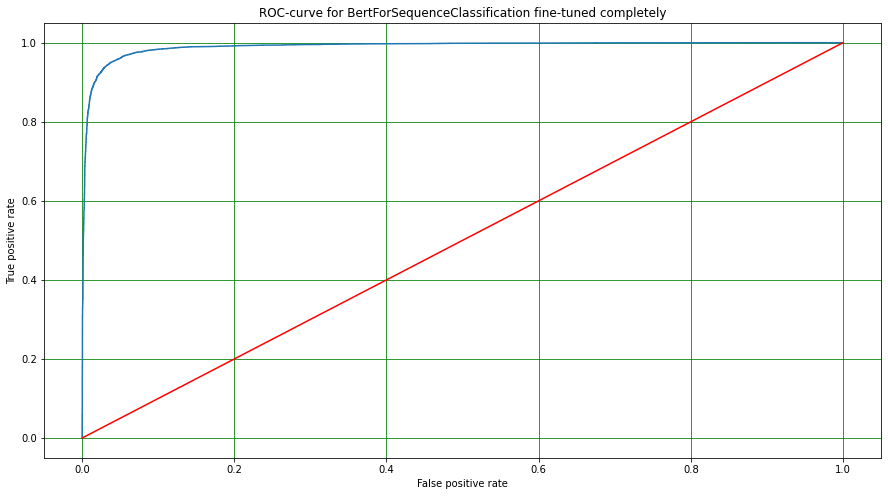

In [ ]:
get_scores(model, train_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, train_dataloader, get_function=get_all_y_for_bert)

Scores for BertForSequenceClassification fine-tuned completely:
Accuracy: 0.90992
Precision: 0.9160441701851251
Recall: 0.90256
Area under ROC-curve: 0.9709


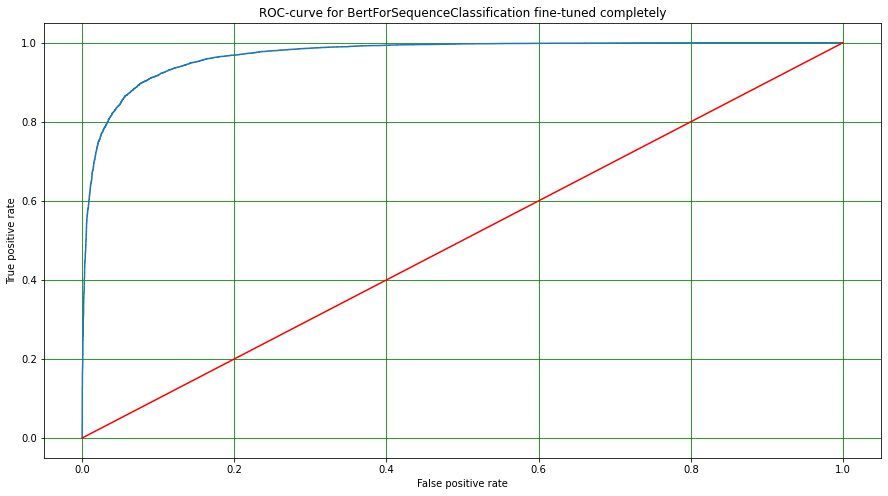

In [ ]:
get_scores(model, test_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, test_dataloader, get_function=get_all_y_for_bert)

We can see that the scores are also very nice and it took five minutes less to train the model and achieve the best scores.

##Model comparison.

Here we will provide scores table for different approaches of BERT layers unfreezing. We also keep the best model from previous notebooks to compare results with it.


Model                             | Accuracy | Precision | Recall    | Roc-auc
----------------------------------|----------|-----------|-----------|--------
LSTM-based NN + attention         | 0.889    | 0.863     | **0.924** | 0.955
BERT (classifier)                 | 0.828    | 0.828     |   0.827   | 0.907
BERT (classifier + transformer x1)| 0.896    | 0.894     |   0.899   | 0.962
BERT (classifier + transformer x6)| 0.909    | **0.927** |   0.889   | **0.971**
BERT (full)                       |**0.910** | 0.916     |   0.903   | **0.971**


We can see that fine-tuning BERT with at least one unfrozen transformer gets better accuracy than the best of previous models - attentive model based on LSTM. According to obtained results and training time we can conclude that the best approach for our problem was fine-tuning the entire model for one epoch. We got +2% accuracy which was the main metric for this research.



##Best model improvement.

Since we discovered that the best approach is to unfreeze BERT completely, we can now apply some quality improvement tricks to the best obtained model. Some of them were proposed [here](https://arxiv.org/pdf/1801.06146.pdf).

###BERT for 512 maximal text length.

In previous experiments we set maximal text length to 200 in order to make training faster. But BERT supports maximal text lengths up to 512, so we will try to use maximum possible value. It will increase training time because we need to reduce betch size to fit GPU memory limits, but may also significantly increase scores.

Let's create new datasets with max_length=512 and new dataloaders with batch_size=8.

In [ ]:
train_dataset = preprocess_data_for_bert(train_data, tokenizer, device=DEVICE, max_length=512)
val_dataset = preprocess_data_for_bert(val_data, tokenizer, device=DEVICE, max_length=512)
test_dataset = preprocess_data_for_bert(test_data, tokenizer, device=DEVICE, max_length=512)

  1%|          | 269/22500 [00:01<02:36, 141.62it/s]

In [ ]:
BATCH_SIZE = 8

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              drop_last=True)

val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                            drop_last=True)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

We can now train model and check its results.

In [ ]:
model, optimizer = get_bert_with_optimizer('BertForSequenceClassification fine-tuned completely with max_length=512')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
metrics = train_bert(model, optimizer, train_dataloader, val_dataloader, device=DEVICE, n_epochs=1)


======== Epoch 1 / 1 ========
Training...
  Batch   100  of  2,812.    Elapsed: 0:02:22.
  Batch   200  of  2,812.    Elapsed: 0:04:45.
  Batch   300  of  2,812.    Elapsed: 0:07:08.
  Batch   400  of  2,812.    Elapsed: 0:09:32.
  Batch   500  of  2,812.    Elapsed: 0:11:55.
  Batch   600  of  2,812.    Elapsed: 0:14:19.
  Batch   700  of  2,812.    Elapsed: 0:16:42.
  Batch   800  of  2,812.    Elapsed: 0:19:05.
  Batch   900  of  2,812.    Elapsed: 0:21:29.
  Batch 1,000  of  2,812.    Elapsed: 0:23:52.
  Batch 1,100  of  2,812.    Elapsed: 0:26:16.
  Batch 1,200  of  2,812.    Elapsed: 0:28:39.
  Batch 1,300  of  2,812.    Elapsed: 0:31:03.
  Batch 1,400  of  2,812.    Elapsed: 0:33:27.
  Batch 1,500  of  2,812.    Elapsed: 0:35:50.
  Batch 1,600  of  2,812.    Elapsed: 0:38:14.
  Batch 1,700  of  2,812.    Elapsed: 0:40:37.
  Batch 1,800  of  2,812.    Elapsed: 0:43:01.
  Batch 1,900  of  2,812.    Elapsed: 0:45:24.
  Batch 2,000  of  2,812.    Elapsed: 0:47:47.
  Batch 2,100  of

In [ ]:
torch.save(model, 'bert-512.pth')

In [ ]:
model = torch.load('bert-512.pth')

Scores for BertForSequenceClassification fine-tuned completely with max_length=512:
Accuracy: 0.9659495021337127
Precision: 0.9650026647717179
Recall: 0.9668921324314703
Area under ROC-curve: 0.9921


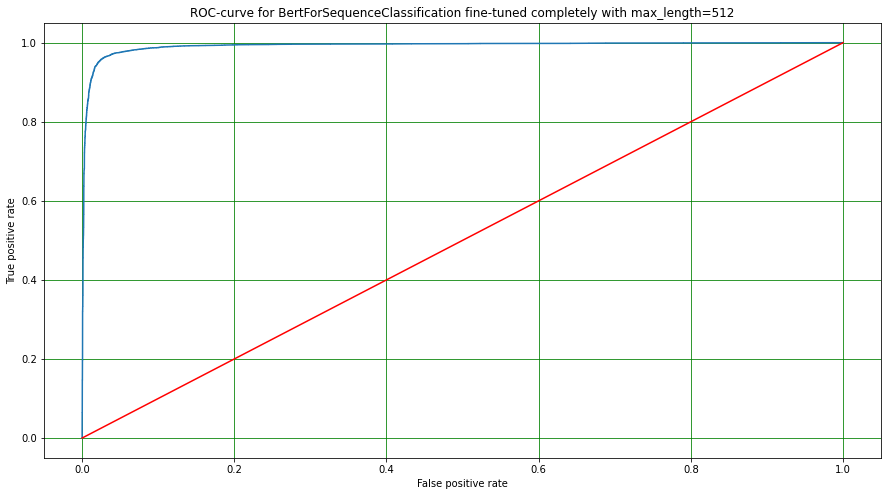

In [ ]:
get_scores(model, train_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, train_dataloader, get_function=get_all_y_for_bert)

Scores for BertForSequenceClassification fine-tuned completely with max_length=512:
Accuracy: 0.93684
Precision: 0.9334074132867688
Recall: 0.9408
Area under ROC-curve: 0.9828


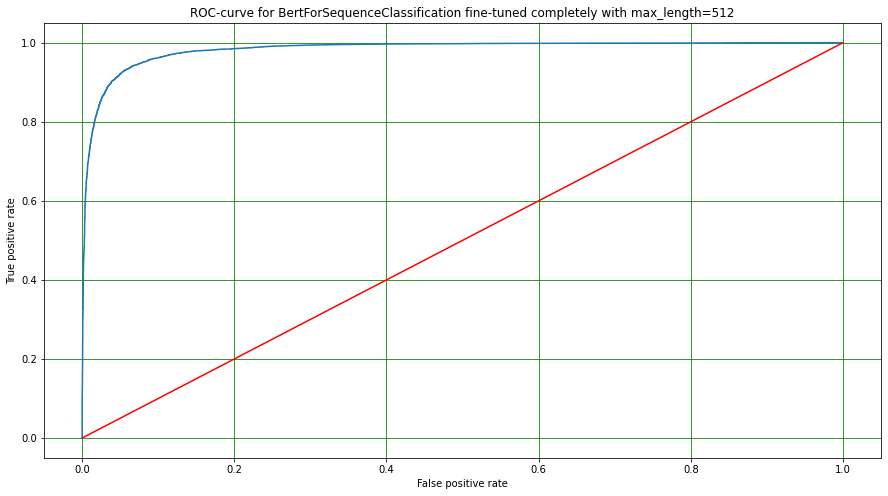

In [ ]:
get_scores(model, test_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, test_dataloader, get_function=get_all_y_for_bert)

We can notice about +2.7% accuracy, which is a huge improvement of quality, so we will later use max_length=512.

###Adding learning rate scheduler.

Another trick is to use learning rate scheduler, which can be useful to BERT fine-tuning. It changes learning rate during training according to some plan which defines the scheduler. We will use [linear scheduler with warm-up](https://huggingface.co/transformers/main_classes/optimizer_schedules.html?highlight=get_linear_schedule_with_warmup#transformers.get_linear_schedule_with_warmup) and set the warm-up proportion to 0.1.

In [ ]:
model, optimizer = get_bert_with_optimizer('BertForSequenceClassification fine-tuned completely with max_length=512')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
metrics = train_bert(model, optimizer, train_dataloader, val_dataloader, device=DEVICE, n_epochs=2, use_scheduler=True)


======== Epoch 1 / 2 ========
Training...
  Batch   100  of  2,812.    Elapsed: 0:01:24.
  Batch   200  of  2,812.    Elapsed: 0:02:48.
  Batch   300  of  2,812.    Elapsed: 0:04:11.
  Batch   400  of  2,812.    Elapsed: 0:05:35.
  Batch   500  of  2,812.    Elapsed: 0:06:58.
  Batch   600  of  2,812.    Elapsed: 0:08:21.
  Batch   700  of  2,812.    Elapsed: 0:09:45.
  Batch   800  of  2,812.    Elapsed: 0:11:08.
  Batch   900  of  2,812.    Elapsed: 0:12:32.
  Batch 1,000  of  2,812.    Elapsed: 0:13:55.
  Batch 1,100  of  2,812.    Elapsed: 0:15:19.
  Batch 1,200  of  2,812.    Elapsed: 0:16:42.
  Batch 1,300  of  2,812.    Elapsed: 0:18:06.
  Batch 1,400  of  2,812.    Elapsed: 0:19:29.
  Batch 1,500  of  2,812.    Elapsed: 0:20:53.
  Batch 1,600  of  2,812.    Elapsed: 0:22:16.
  Batch 1,700  of  2,812.    Elapsed: 0:23:40.
  Batch 1,800  of  2,812.    Elapsed: 0:25:03.
  Batch 1,900  of  2,812.    Elapsed: 0:26:27.
  Batch 2,000  of  2,812.    Elapsed: 0:27:50.
  Batch 2,100  of

Scores for BertForSequenceClassification fine-tuned completely with max_length=512:
Accuracy: 0.989775960170697
Precision: 0.9874158099964552
Recall: 0.9921638468388245
Area under ROC-curve: 0.9974


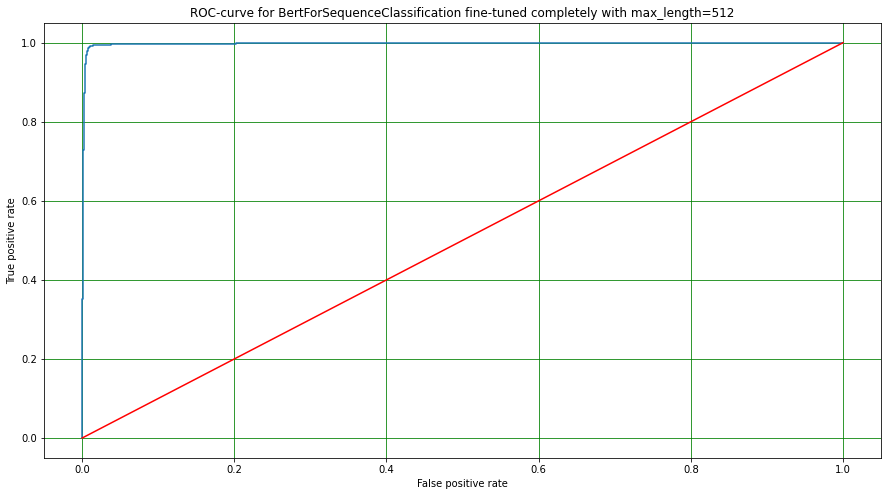

In [ ]:
model.eval()
get_scores(model, train_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, train_dataloader, get_function=get_all_y_for_bert)

Scores for BertForSequenceClassification fine-tuned completely with max_length=512:
Accuracy: 0.9398
Precision: 0.931210291003216
Recall: 0.94976
Area under ROC-curve: 0.9838


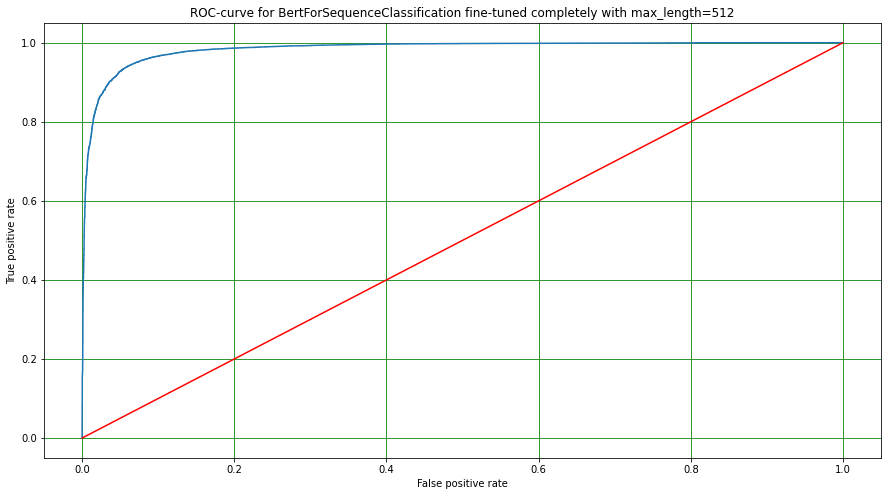

In [ ]:
get_scores(model, test_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, test_dataloader, get_function=get_all_y_for_bert)

As we can see scheduler usage gives us extra +0.3% to test accuracy (final model comparison will be provided below).

###Discriminative fine-tuning.

This trick follows the natural idea that first layers of pre-trained model learned more general language features and last layers are more task-specific. So the main idea is to use as lower learning rate as further the layer is from the output.

We will set learning rate to 2e-5 at classifier layer and multiply by 0.95 by getting deeper into network. Note that inside one part of the model (classifier, transformer or embedding layer) learning rate remains the same and changes between this parts.

In [ ]:
def get_bert_with_optimizer_discriminative(name, decrease_coeff=0.95, device=DEVICE):
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    ).to(device)
    model.name = name
    lr = 2e-5
    param_slices = [slice(0, 5)] + [slice(5 + 16 * i, 5 + 16 * (i + 1)) for i in range(12)] + [slice(5 + 16 * 12, len(list(model.parameters())))]

    optim_list = []

    for param_slice in reversed(param_slices):
        optim_list.append({'params': list(model.parameters())[param_slice],
                           'lr': lr})
        lr *= decrease_coeff
        
    optimizer = AdamW(optim_list, lr=2e-5, eps=1e-8)
    return model, optimizer

In [ ]:
model, optimizer = get_bert_with_optimizer_discriminative('BertForSequenceClassification fine-tuned completely with max_length=512 + ' +
                                                          'scheduler + discriminative fine-tuning', device=DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
metrics = train_bert(model, optimizer, train_dataloader, val_dataloader, device=DEVICE, n_epochs=2, use_scheduler=True)


======== Epoch 1 / 2 ========
Training...
  Batch   100  of  2,812.    Elapsed: 0:02:22.
  Batch   200  of  2,812.    Elapsed: 0:04:44.
  Batch   300  of  2,812.    Elapsed: 0:07:06.
  Batch   400  of  2,812.    Elapsed: 0:09:29.
  Batch   500  of  2,812.    Elapsed: 0:11:51.
  Batch   600  of  2,812.    Elapsed: 0:14:14.
  Batch   700  of  2,812.    Elapsed: 0:16:36.
  Batch   800  of  2,812.    Elapsed: 0:18:59.
  Batch   900  of  2,812.    Elapsed: 0:21:21.
  Batch 1,000  of  2,812.    Elapsed: 0:23:44.
  Batch 1,100  of  2,812.    Elapsed: 0:26:06.
  Batch 1,200  of  2,812.    Elapsed: 0:28:28.
  Batch 1,300  of  2,812.    Elapsed: 0:30:51.
  Batch 1,400  of  2,812.    Elapsed: 0:33:13.
  Batch 1,500  of  2,812.    Elapsed: 0:35:35.
  Batch 1,600  of  2,812.    Elapsed: 0:37:58.
  Batch 1,700  of  2,812.    Elapsed: 0:40:20.
  Batch 1,800  of  2,812.    Elapsed: 0:42:42.
  Batch 1,900  of  2,812.    Elapsed: 0:45:05.
  Batch 2,000  of  2,812.    Elapsed: 0:47:27.
  Batch 2,100  of

Scores for BertForSequenceClassification fine-tuned completely with max_length=512 + scheduler + discriminative fine-tuning:
Accuracy: 0.9800408961593172
Precision: 0.9784784341510938
Recall: 0.9816953971921095
Area under ROC-curve: 0.9956


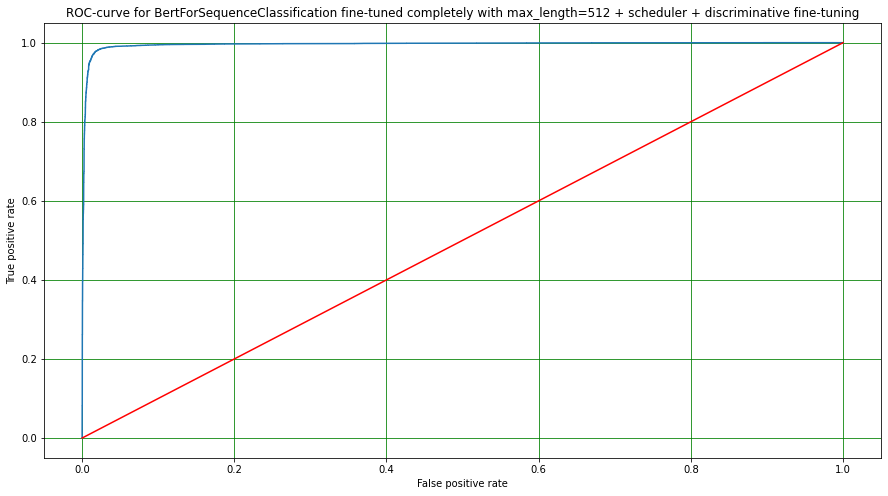

In [ ]:
model.eval()
get_scores(model, train_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, train_dataloader, get_function=get_all_y_for_bert)

Scores for BertForSequenceClassification fine-tuned completely with max_length=512 + scheduler + discriminative fine-tuning:
Accuracy: 0.94088
Precision: 0.937450388950627
Recall: 0.9448
Area under ROC-curve: 0.9846


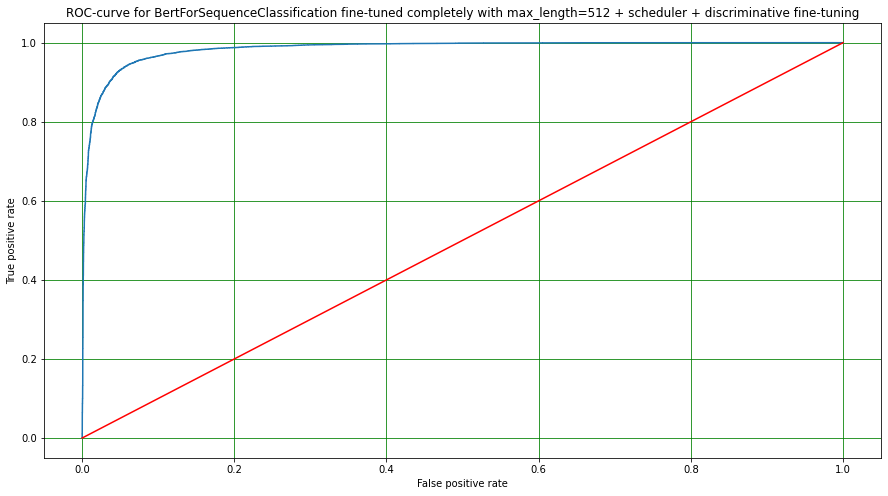

In [ ]:
get_scores(model, test_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, test_dataloader, get_function=get_all_y_for_bert)

So we get extra +0.1% of accuracy by using discriminative fine-tuning. Let's create a table of tricks improvements.

##Tricks improvements.

Here are meanings of words in brackets:

1) 200/512 - max_length used when fine-tuning the model.

2) full - fine-tuned without frozen layers.

3) scheduler - fine-tuned using linear scheduler with warm-up.

4) discr - discriminative fine-tuning.

Model                                 | Accuracy | Precision | Recall    | Roc-auc
--------------------------------------|----------|-----------|-----------|--------
BERT (200 + full)                     | 0.910    | 0.916     |   0.903   | 0.971  
BERT (512 + full)                     | 0.937    | 0.933     |   0.941   | 0.983 
BERT (512 + full + scheduler)         | 0.940    | 0.931     | **0.950** | 0.984
BERT (512 + full + scheduler + discr) | **0.941**| **0.937** |   0.945   | **0.985**

We can see that all applied tricks were useful and increased acciracy score up to 94.1%.

##Appendix. Longer training of models with two last unfreezing approaches.

Here we also provide the code of training last two models for 4 epochs like for the first two ones. For both models test scores get worse and train scores become almost ideal, so that shows the overfitting of such large models.

In [ ]:
train_dataset = preprocess_data_for_bert(train_data, tokenizer, device=DEVICE)
val_dataset = preprocess_data_for_bert(val_data, tokenizer, device=DEVICE)
test_dataset = preprocess_data_for_bert(test_data, tokenizer, device=DEVICE)

100%|██████████| 25000/25000 [02:55<00:00, 142.84it/s]


In [ ]:
BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              drop_last=True)

val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                            drop_last=True)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

First we will train the model with unfrozen classifier and 6 transformers:

In [ ]:
model, optimizer = get_bert_with_optimizer('BertForSequenceClassification with fine-tuned classifier and last 6 transformers')

n_parameters = len(list(model.parameters()))

for i, param in enumerate(model.parameters()):
    if i < n_parameters - 4 - 6 * 16:
        param.requires_grad = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
metrics = train_bert(model, optimizer, train_dataloader, val_dataloader, device=DEVICE, n_epochs=4)


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  1,406.    Elapsed: 0:00:40.
  Batch   200  of  1,406.    Elapsed: 0:01:20.
  Batch   300  of  1,406.    Elapsed: 0:01:59.
  Batch   400  of  1,406.    Elapsed: 0:02:39.
  Batch   500  of  1,406.    Elapsed: 0:03:19.
  Batch   600  of  1,406.    Elapsed: 0:03:59.
  Batch   700  of  1,406.    Elapsed: 0:04:39.
  Batch   800  of  1,406.    Elapsed: 0:05:19.
  Batch   900  of  1,406.    Elapsed: 0:05:58.
  Batch 1,000  of  1,406.    Elapsed: 0:06:38.
  Batch 1,100  of  1,406.    Elapsed: 0:07:18.
  Batch 1,200  of  1,406.    Elapsed: 0:07:58.
  Batch 1,300  of  1,406.    Elapsed: 0:08:37.
  Batch 1,400  of  1,406.    Elapsed: 0:09:17.

  Average training loss: 0.29
  Training epoch took: 0:09:19

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.23
  Validation took: 0:00:32

======== Epoch 2 / 4 ========
Training...
  Batch   100  of  1,406.    Elapsed: 0:00:40.
  Batch   200  of  1,406.    Elapsed: 0:01:19.
  Batch  

Scores for BertForSequenceClassification with fine-tuned classifier and last 6 transformers:
Accuracy: 0.9948435277382646
Precision: 0.9934385529349176
Recall: 0.9962653387871243
Area under ROC-curve: 0.9992


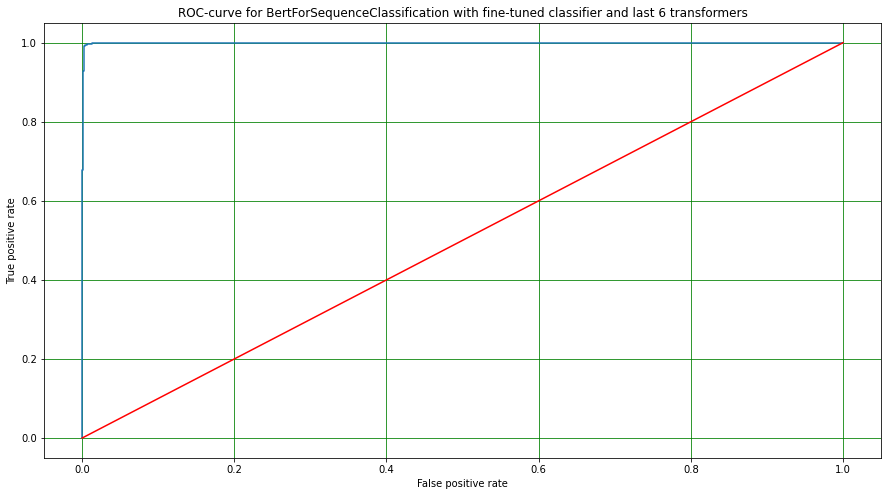

In [ ]:
model.eval()
get_scores(model, train_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, train_dataloader, get_function=get_all_y_for_bert)

Scores for BertForSequenceClassification with fine-tuned classifier and last 6 transformers:
Accuracy: 0.90824
Precision: 0.902127659574468
Recall: 0.91584
Area under ROC-curve: 0.9681


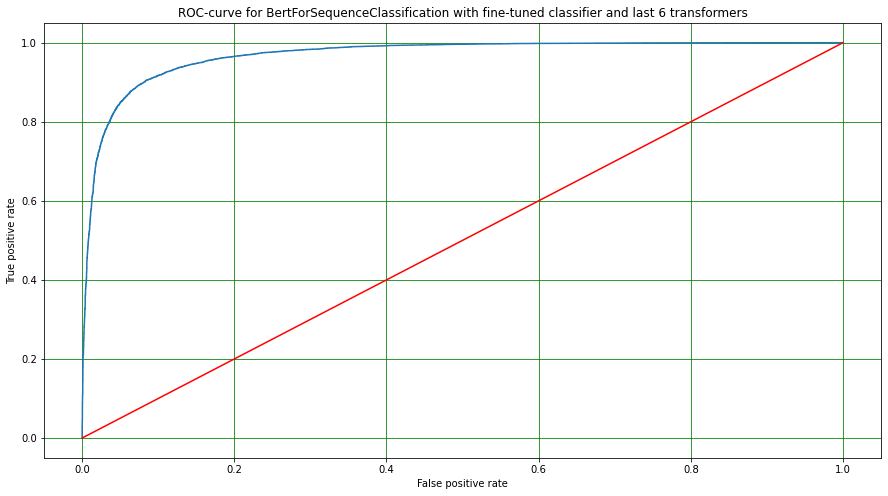

In [ ]:
get_scores(model, test_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, test_dataloader, get_function=get_all_y_for_bert)

And for the second model with the entire BERT fine-tuned:

In [ ]:
model, optimizer = get_bert_with_optimizer('BertForSequenceClassification fine-tuned completely')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
metrics = train_bert(model, optimizer, train_dataloader, val_dataloader, device=DEVICE, n_epochs=2)


======== Epoch 1 / 2 ========
Training...
  Batch   100  of  1,406.    Elapsed: 0:00:59.
  Batch   200  of  1,406.    Elapsed: 0:02:02.
  Batch   300  of  1,406.    Elapsed: 0:03:04.
  Batch   400  of  1,406.    Elapsed: 0:04:05.
  Batch   500  of  1,406.    Elapsed: 0:05:07.
  Batch   600  of  1,406.    Elapsed: 0:06:09.
  Batch   700  of  1,406.    Elapsed: 0:07:12.
  Batch   800  of  1,406.    Elapsed: 0:08:14.
  Batch   900  of  1,406.    Elapsed: 0:09:16.
  Batch 1,000  of  1,406.    Elapsed: 0:10:18.
  Batch 1,100  of  1,406.    Elapsed: 0:11:20.
  Batch 1,200  of  1,406.    Elapsed: 0:12:22.
  Batch 1,300  of  1,406.    Elapsed: 0:13:24.
  Batch 1,400  of  1,406.    Elapsed: 0:14:26.

  Average training loss: 0.30
  Training epoch took: 0:14:30

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.23
  Validation took: 0:00:33

======== Epoch 2 / 2 ========
Training...
  Batch   100  of  1,406.    Elapsed: 0:01:02.
  Batch   200  of  1,406.    Elapsed: 0:02:04.
  Batch  

Scores for BertForSequenceClassification fine-tuned completely:
Accuracy: 0.981374466571835
Precision: 0.990934638745354
Recall: 0.9716444444444444
Area under ROC-curve: 0.9974


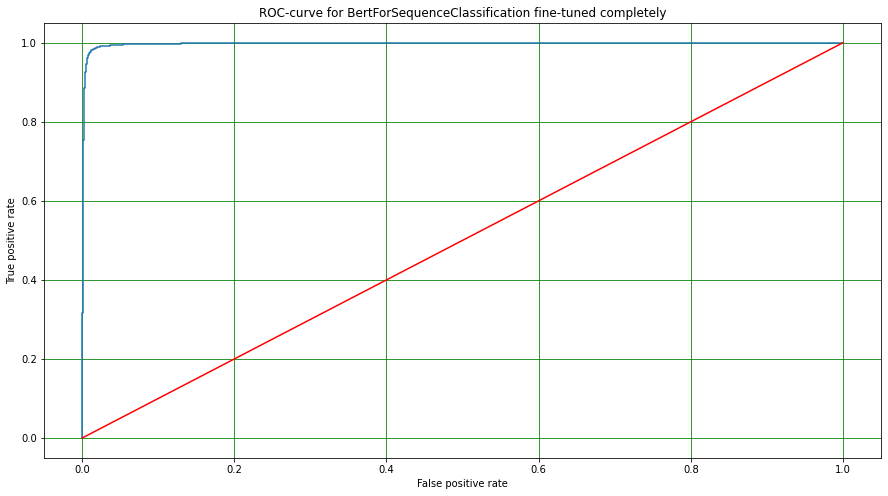

In [ ]:
get_scores(model, train_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, train_dataloader, get_function=get_all_y_for_bert)

Scores for BertForSequenceClassification fine-tuned completely:
Accuracy: 0.90424
Precision: 0.9304821945817005
Recall: 0.87376
Area under ROC-curve: 0.9699


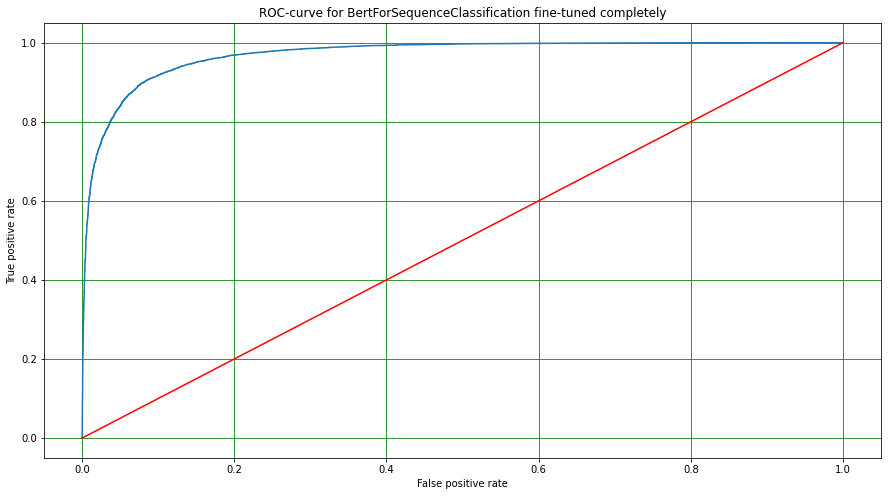

In [ ]:
get_scores(model, test_dataloader, print_scores=True, from_iter=True, get_function=get_all_y_for_bert)
plot_roc_curve(model, test_dataloader, get_function=get_all_y_for_bert)